In [1]:
import pandas as pd
import numpy as np
import math
import os
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import seaborn as sns

# Processing the Forecast 2023 CSV Files

## in this cell, what i am doing is:

- merging all the forecast files that I have in my directory "Forecast_2023".
- converting my field `time` to datetime format.
- sorting the data by `time`.
- dropping my two columns `latitude` and `longitude` since they are always the same.
- and converting my `t2m` column from Kelvin to Celsius.
- finally, displaying all my `merged_forecast`.


In [2]:
# adding all the forecast files of 2023 and merging them up together
# my directory containing my forecast 2023 CSV files
directory = 'Forecast_2023'

# listing everyy file in the directory
forecast_files = [file for file in os.listdir(directory) if 'Forecast' in file]

# merging all the forecast data
merged_forecast = pd.DataFrame()

for file in forecast_files:
    file_path = os.path.join(directory, file)
    forecast_data = pd.read_csv(file_path)
    merged_forecast = pd.concat([merged_forecast, forecast_data], ignore_index=True)

# converting column time to datetime
merged_forecast['time'] = pd.to_datetime(merged_forecast['time'])

# corting by the 'time' column
merged_forecast = merged_forecast.sort_values('time')

# dropping my 'latitude' and 'longitude' columns
merged_forecast = merged_forecast.drop(columns=['latitude', 'longitude'])


merged_forecast['t2m'] = merged_forecast['t2m'] - 273.15

# display the first few rows of the sorted DataFrame to verify
merged_forecast

,time,number,cape,sp,tcw,sshf,slhf,msl,u10,v10,...,skt,cin,sm,st,sd,sf,tcc,tp,mx2t6,mn2t6
0,2023-02-01,1,61.072380,101409.610,10.740416,99.5,-80.0,102353.240,4.331629,0.622812,...,277.56506,0.000153,366.63710,278.04790,0.0,2.384186e-07,99.999405,0.000000,NaN,NaN
27,2023-02-01,28,13.732903,101381.770,9.731780,99.5,-80.0,102326.170,4.260235,0.437079,...,276.88498,NaN,367.42755,277.72678,0.0,2.384186e-07,82.492035,0.000000,NaN,NaN
28,2023-02-01,29,39.736767,101421.484,10.473551,99.5,-80.0,102367.710,4.154129,0.477649,...,276.30566,-0.963523,365.71250,278.16490,0.0,2.384186e-07,82.115120,0.000000,NaN,NaN
29,2023-02-01,30,32.167282,101371.100,10.302399,99.5,-80.0,102313.610,4.573876,1.447302,...,278.80304,NaN,362.59756,278.85626,0.0,2.384186e-07,98.961750,0.000000,NaN,NaN
30,2023-02-01,31,58.039753,101377.590,10.323003,99.5,-80.0,102321.290,4.270083,0.192184,...,277.45593,0.000153,366.68073,278.31046,0.0,2.384186e-07,95.708400,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88419,2023-07-07,20,0.000000,101305.875,15.492667,-16413501.0,-66488300.0,102167.470,-0.733916,-1.568665,...,283.55334,NaN,280.03708,290.24515,0.0,0.000000e+00,0.000000,19.842358,292.87920,285.90112
88420,2023-07-07,21,0.000000,101139.086,24.249985,-25520240.0,-57869970.0,101998.200,-1.519770,-0.772716,...,285.79242,NaN,202.88474,291.71527,0.0,0.000000e+00,0.584446,6.819519,294.90670,287.40240
88421,2023-07-07,22,0.000000,101138.380,25.729910,-16826180.0,-64280210.0,101997.945,-1.302365,-1.339807,...,286.52478,NaN,250.58415,291.26083,0.0,0.000000e+00,10.692478,7.399574,294.36798,287.96848
88411,2023-07-07,12,138.721310,100739.500,29.523367,-19495964.0,-63400716.0,101594.586,-1.640700,-0.297045,...,289.80576,-47.982200,229.89012,293.27335,0.0,0.000000e+00,37.850178,4.468890,296.44330,290.78420


### Adding and Merging VLINDER Data

in this cell, what i am doing is:

- Adding the VLINDER data and merging it with the previously merged forecast data.
- The merging is done on the `datetime` columns to align the datasets.
- after merging, dropping the `datetime` column.
- handling the missing values so they are removed.
- displaying both `t2m` and `temp` to show the conversion is working properly and also showing my merged data


In [3]:
# adding the vlinder data of 2023 and merging it with the merged_forecast we made
vlinder_data = pd.read_csv('vlinder19_2023.csv')
vlinder_data['datetime'] = pd.to_datetime(vlinder_data['datetime'])

# merging on datetime columns
merged_data = pd.merge(merged_forecast, vlinder_data, left_on='time', right_on='datetime', how='inner')

# dropping the datetime column
merged_data.drop('datetime', axis=1, inplace=True)

# dropping the NaN data
merged_data = merged_data.dropna()

# showing the t2m and temp first values
print(merged_data['t2m'].head())
print(merged_data['temp'].head())

merged_data

328    7.82314
366    8.14102
368    8.20380
376    8.49975
389    8.14460
Name: t2m, dtype: float64
328    9.5
366    8.5
368    8.5
376    8.5
389    8.5
Name: temp, dtype: float64


,time,number,cape,sp,tcw,sshf,slhf,msl,u10,v10,...,cin,sm,st,sd,sf,tcc,tp,mx2t6,mn2t6,temp
328,2023-02-02 12:00:00,3,44.089370,101794.600,17.190365,3065420.5,-2805246.0,102738.220,4.966050,1.556755,...,0.000153,363.03076,279.17267,0.0,2.384186e-07,99.999405,0.458795,280.94885,279.50055,9.5
366,2023-02-02 18:00:00,45,12.882618,101874.680,17.029846,3256927.5,-3326616.0,102815.555,4.168408,0.209721,...,0.000153,361.38846,279.73978,0.0,2.384186e-07,99.999405,0.702622,283.07913,281.33390,8.5
368,2023-02-02 18:00:00,47,19.331482,101826.805,15.424338,3706666.5,-3326859.5,102766.060,5.150689,0.403272,...,-0.471931,363.81638,279.46384,0.0,2.384186e-07,93.204290,1.327566,282.83838,281.44287,8.5
376,2023-02-02 18:00:00,1,27.119955,101883.960,15.881964,2724135.0,-3329539.5,102824.516,5.405491,1.188883,...,-0.250963,361.65033,279.76694,0.0,2.384186e-07,99.999405,0.528922,282.39030,281.66010,8.5
389,2023-02-02 18:00:00,12,38.224983,101959.490,16.298378,3196451.5,-3179706.5,102901.660,4.902780,1.612116,...,0.000153,360.66590,279.48965,0.0,2.384186e-07,99.999405,0.852857,281.89386,281.27872,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88258,2023-07-07 00:00:00,36,3.930176,101067.375,21.550340,-20435696.0,-56867670.0,101927.540,0.529110,1.857198,...,-45.133286,218.11652,289.95530,0.0,0.000000e+00,57.399390,6.380605,292.19340,286.51750,17.5
88269,2023-07-07 00:00:00,47,8.890320,101112.016,22.093838,-21840656.0,-65307064.0,101972.410,1.733405,2.050355,...,-7.350601,220.22717,291.70862,0.0,0.000000e+00,64.499730,6.068488,294.16190,288.86682,17.5
88279,2023-07-07 00:00:00,4,122.946440,100850.230,30.957127,-22055496.0,-62739930.0,101704.210,0.073889,1.348715,...,-25.752014,216.85493,293.02340,0.0,0.000000e+00,60.558150,5.818337,294.90920,289.65543,17.5
88281,2023-07-07 00:00:00,6,9.296875,101305.960,19.166512,-25560424.0,-51502996.0,102167.820,-0.429665,-1.844369,...,-21.556335,203.33162,290.54290,0.0,0.000000e+00,1.213146,8.216012,293.57007,286.84427,17.5


### Manually Splitting My Data

in this cell i am doing a manual splitting :
- manually splitting my data into three sections: `trainset`, `validateset`, and `testset`.
- wheere the sizes are 60% for the `trainset`, and 20% each for the `validateset` and `testset`.


In [4]:
# the length of all my data
total_length = len(merged_data)

# calculate the number of rows for each split
train_size = int(total_length * 0.6)  
validate_size = int(total_length * 0.2) 
test_size = total_length - train_size - validate_size 

# performing the spliting
trainset = merged_data[:train_size]
validateset = merged_data[train_size:train_size + validate_size]
testset = merged_data[train_size + validate_size:]

# displaying the sizes of the datasets to make sure my spiting is correct
print(f"Training set size: {len(trainset)}")
print(f"Validation set size: {len(validateset)}")
print(f"Test set size: {len(testset)}")


Training set size: 8960
Validation set size: 2986
Test set size: 2988


### Correlation matrix and plotting

here i am:
- listing the feature columns based on my merged_data columns.
- combining all data for the correlation matrix, including the target variable `temp` .
- calculating the correlation matrix.
- extracting correlation values with `temp`.
- plotting the correlation values and showing a graph with the correlation of features with the `temp`.


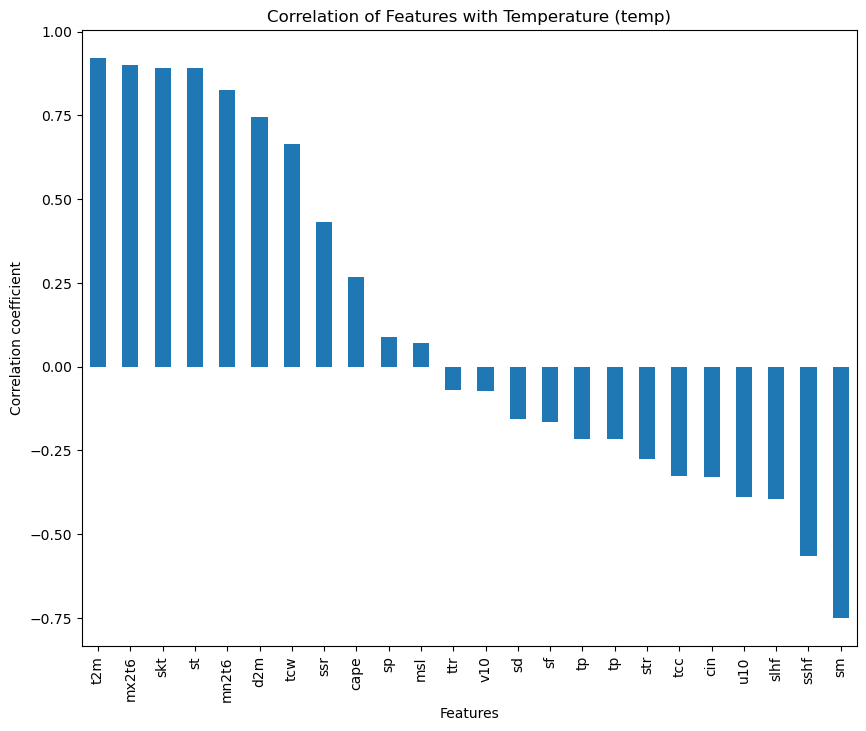

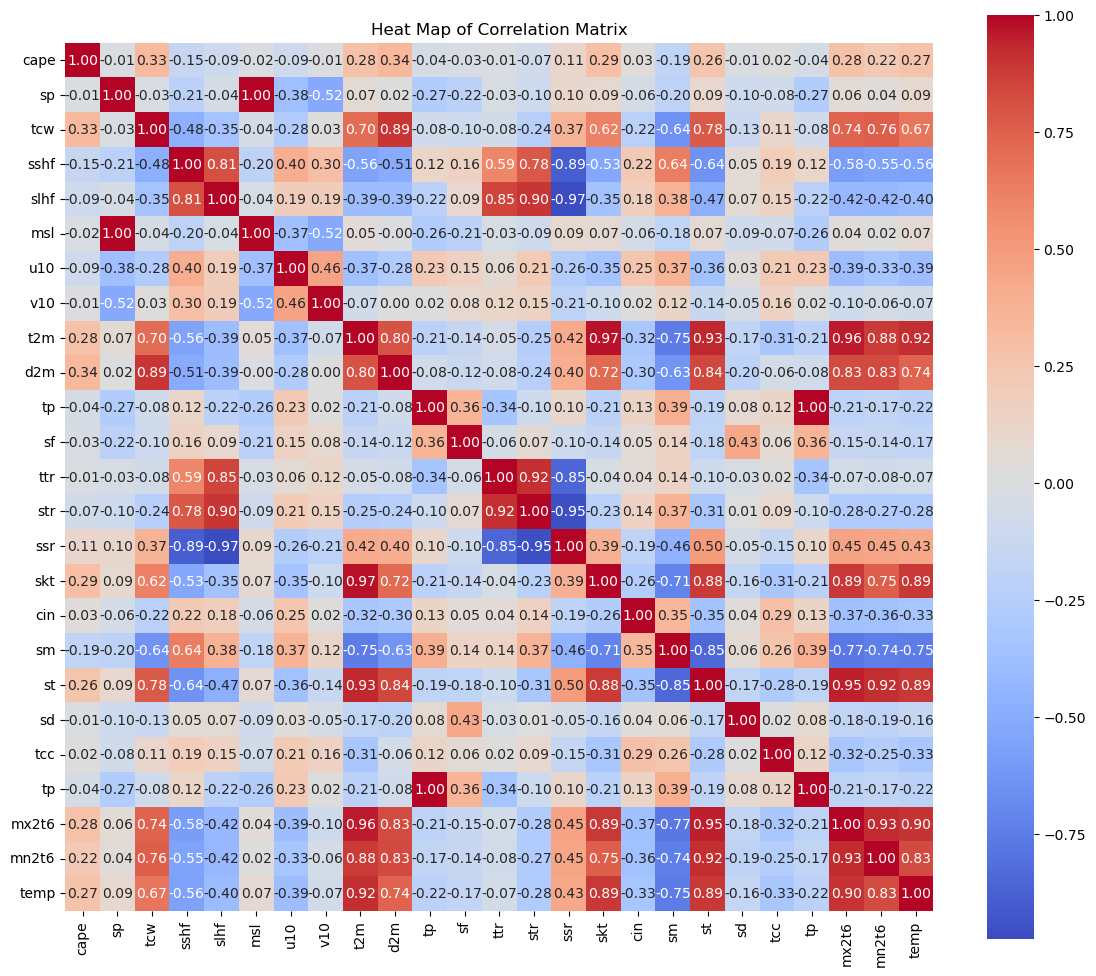

In [5]:
# List of feature columns based merged_data columns
feature_columns = ['cape', 'sp', 'tcw', 'sshf', 'slhf', 'msl', 'u10', 'v10', 't2m', 
                   'd2m', 'tp', 'sf', 'ttr', 'str', 'ssr', 
                   'skt', 'cin', 'sm', 'st', 'sd', 'tcc', 'tp', 'mx2t6', 'mn2t6']

# adding it the features columns with my temp
all_data = merged_data[feature_columns + ['temp']]

# calculate the correlation matrix
correlation_matrix = all_data.corr()

# extracting the correlation values with 'temp'
correlation_with_temp = correlation_matrix['temp'].drop('temp').sort_values(ascending=False)

# plotting the correlation values
plt.figure(figsize=(10, 8))
correlation_with_temp.plot(kind='bar')
plt.title('Correlation of Features with Temperature (temp)')
plt.ylabel('Correlation coefficient')
plt.xlabel('Features')
plt.show()

# making a heat map of the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heat Map of Correlation Matrix')
plt.show()


### Linear Regression Model Training and Validation

In this section of Linear Regression, i am:
- extracting the features and target variable from both the training and validation datasets.
- initializing the Linear Regression model.
- fitting the model to the training data.
- using the model to make predictions on the validation dataset.
- calculating the Mean Squared Error (MSE) to evaluate the model's performance on the validation set.
- comparing between my diffrent models and features used for it and finding the one best using the Mean Squared Error (MSE)


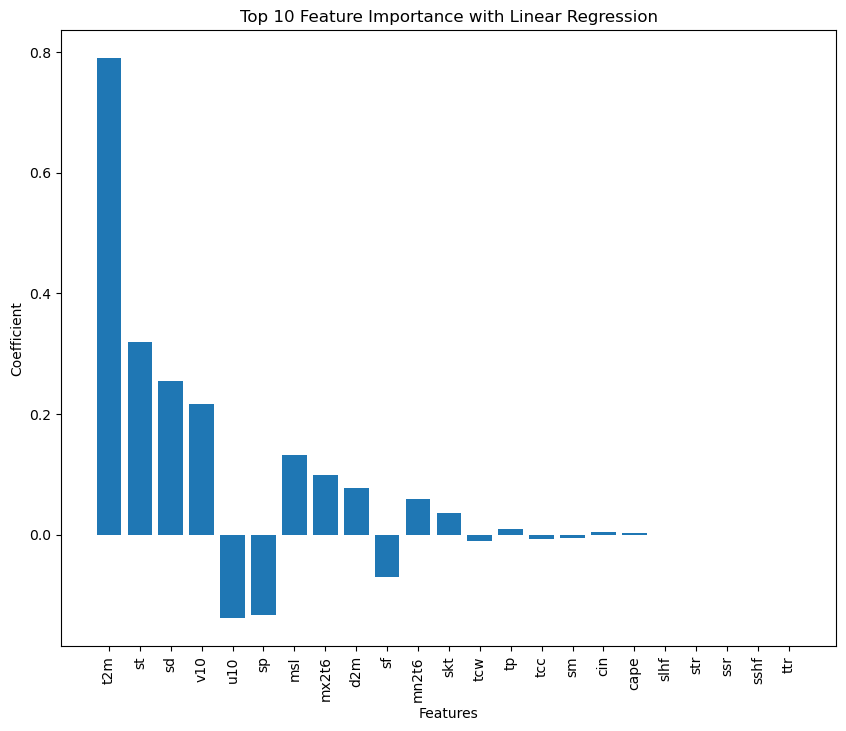

In [6]:
# extracting the features and target for training
train_features = trainset[feature_columns]
train_target = trainset['temp']

# extracting the and target for validation
validate_features = validateset[feature_columns]
validate_target = validateset['temp']

# initializing the Linear Regression model
linear_regression_model = LinearRegression()

# training the model
linear_regression_model.fit(train_features, train_target)


# getting feature coefficients
feature_coefficients = linear_regression_model.coef_

# creating a DataFrame for the feature coefficients
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': feature_coefficients
})

# Sort the DataFrame by absolute coefficient value
importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# selecting top 10 features
top_10_features = importance_df.head(10)
top_10_feature_list = top_10_features['Feature'].tolist()

# Plot the feature coefficients for the top 10 features
plt.figure(figsize=(10, 8))
plt.bar(importance_df['Feature'], importance_df['Coefficient'])
plt.xticks(rotation=90)
plt.title('Top 10 Feature Importance with Linear Regression')
plt.ylabel('Coefficient')
plt.xlabel('Features')
plt.show()

In [7]:
# displaying the top 10 features based on the importance on the plotting
print("Top 10 Features:")
print(top_10_feature_list)

Top 10 Features:
['t2m', 'st', 'sd', 'v10', 'u10', 'sp', 'msl', 'mx2t6', 'd2m', 'sf']


- calculating the MSE using all features

In [8]:
# checking the model performance on validation data based on 
predictions = linear_regression_model.predict(validate_features)
mse = mean_squared_error(validate_target, predictions)
print(f"Mean Squared Error on validation set using all features: {mse}")

Mean Squared Error on validation set using all features: 8.453646459257168


- training my model and calculating Mean Squared Error on validation set using the Recursive Feature Elimination with Cross-Validation (RFECV)

In [9]:
# initializing the LinearRegression model
linear_regression_model_2 = LinearRegression()

# intializing the RFECV with the LinearRegression model
rfecv_lr = RFECV(estimator=linear_regression_model_2, step=1, cv=10, scoring='neg_mean_squared_error')

# fitting using RFECV to the training data
rfecv_lr.fit(train_features, train_target)

# getting the features selected by RFECV
selected_features = np.array(feature_columns)[rfecv_lr.support_].tolist()
print(f"Selected features: {selected_features}")

# checking the model performance on validation data
predictions = rfecv_lr.predict(validate_features)
mse = mean_squared_error(validate_target, predictions)
print(f"Mean Squared Error on validation set using RFECV: {mse}")

Selected features: ['t2m', 'sf', 'st', 'sd']
Mean Squared Error on validation set using RFECV: 9.488283371792274


- training my model and calculating Mean Squared Error on validation set using the top 10 selected feature from my model

In [10]:
# secleting top 10 features based on absolute correlation with the target variable using linear regression
print("Top 10 features farthest from zero for evaluation with linear regression:", top_10_feature_list)

# trainingthe model using only the selected features
selected_train_features = trainset[top_10_feature_list]
selected_validate_features = validateset[top_10_feature_list]

# initializing the Linear Regression model
optimized_linear_regression_model = LinearRegression()

# Fit the model on the training data
optimized_linear_regression_model.fit(selected_train_features, train_target)

# Predict on the validation set
validate_predictions = optimized_linear_regression_model.predict(selected_validate_features)

# Calculate the Mean Squared Error (MSE) 
mse = mean_squared_error(validate_target, validate_predictions)
print(f"Validation MSE: {mse}")

Top 10 features farthest from zero for evaluation with linear regression: ['t2m', 'st', 'sd', 'v10', 'u10', 'sp', 'msl', 'mx2t6', 'd2m', 'sf']
Validation MSE: 7.938194446129165


- training my model and calculating Mean Squared Error on validation set using the top 10 selected correlation matrix

In [11]:
# Select top 10 features based on absolute correlation with the target variable
top_10_features = correlation_with_temp.abs().nlargest(10).index.tolist()
print("Top 10 features farthest from zero for evaluation:", top_10_features)

# trainingthe model using only the selected features
selected_train_features = trainset[top_10_features]
selected_validate_features = validateset[top_10_features]

# initializing the Linear Regression model
second_optimized_linear_regression_model = LinearRegression()

# Fit the model on the training data
second_optimized_linear_regression_model.fit(selected_train_features, train_target)

# Predict on the validation set
validate_predictions = second_optimized_linear_regression_model.predict(selected_validate_features)

# Calculate the Mean Squared Error 
mse = mean_squared_error(validate_target, validate_predictions)
print(f"Validation MSE: {mse}")

Top 10 features farthest from zero for evaluation: ['t2m', 'mx2t6', 'skt', 'st', 'mn2t6', 'sm', 'd2m', 'tcw', 'sshf', 'ssr']
Validation MSE: 7.678889828063584


# Random Forest Model Training and Validation with Feature Selection and Hyperparameter Tuning

what im doing in this section:

- Feature Extraction: Extracting features and the target variable from the training and validation datasets.
- findning the best feature importance for the model this model
- using Hyperparameter Tuning: Performing hyperparameter tuning with GridSearchCV to find the best parameters for the model.
- training my model with all features and making predictions on the validation dataset, and calculating the MSE to evaluate performance.


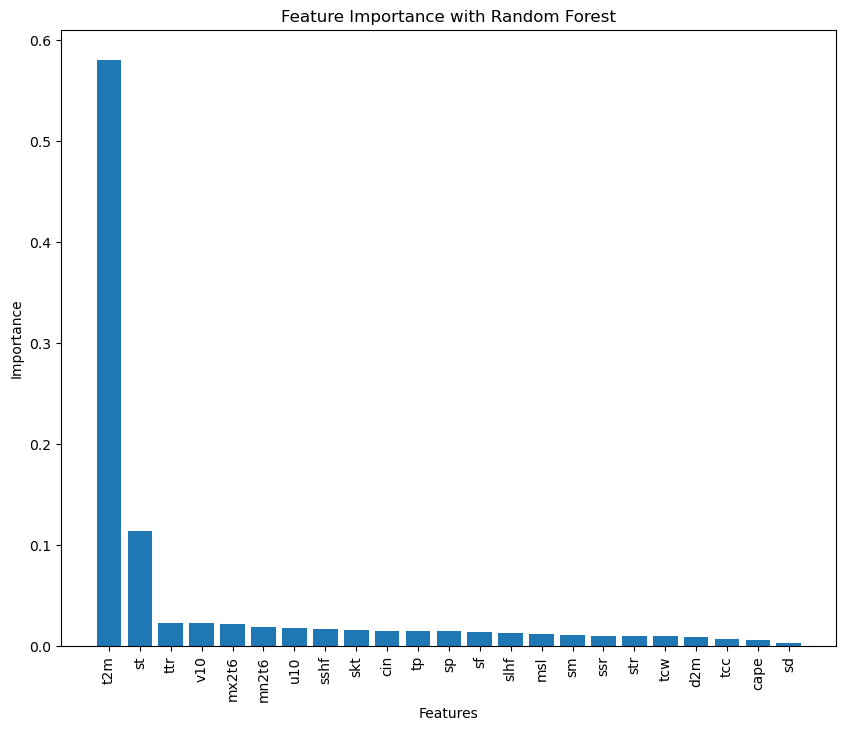

In [12]:
# initializing the RandomForest model
first_rf_model = RandomForestRegressor(random_state=42)

# training the model
first_rf_model.fit(train_features, train_target)

# getting feature importances
feature_importances = first_rf_model.feature_importances_

# creating a DataFrame for the feature importances
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# sorting the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plotting the feature importances
plt.figure(figsize=(10, 8))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance with Random Forest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [13]:
# initializing the RandomForest model
first_rf_model = RandomForestRegressor(random_state=42)

# trainingthe model
first_rf_model.fit(train_features, train_target)

# Predict on the validation set
val_predictions = first_rf_model.predict(validate_features)

# Calculate the MSE
mse = mean_squared_error(validate_target, val_predictions)

# Print the MSE
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 40.425783800401874


In [14]:
# Select top 10 features based on absolute correlation with the target variable
top_10_feature_names = correlation_with_temp.abs().nlargest(10).index.tolist()
print("Top 10 features farthest from zero for evaluation:", top_10_feature_names)

# extract the top 10 features for training and validation sets
top_10_train_features = train_features[top_10_feature_names]
top_10_validate_features = validate_features[top_10_feature_names]

# initializing the RandomForest model
second_rf_model = RandomForestRegressor(random_state=42)

# my parameter grid Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=second_rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(top_10_train_features, train_target)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# training the RandomForest model with the best parameters
best_second_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_second_rf_model.fit(top_10_train_features, train_target)

# model performance check on validation data
validate_predictions1 = best_second_rf_model.predict(top_10_validate_features)
mse = mean_squared_error(validate_target, validate_predictions1)
print(f"Mean Squared Error on validation set: {mse}")

Top 10 features farthest from zero for evaluation: ['t2m', 'mx2t6', 'skt', 'st', 'mn2t6', 'sm', 'd2m', 'tcw', 'sshf', 'ssr']
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error on validation set: 46.33182077980204


In [15]:
# initializing the RandomForest model
fourth_rf_model = RandomForestRegressor(random_state=42)

# hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=fourth_rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_target)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# training the RandomForest model with the best parameters
best_fourth_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_fourth_rf_model.fit(train_features, train_target)

# model performance check on validation data
validate_predictions = best_fourth_rf_model.predict(validate_features)
mse = mean_squared_error(validate_target, validate_predictions)
print(f"Mean Squared Error on validation set: {mse}")

Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Mean Squared Error on validation set: 39.12514804620464


In [16]:
important_features = ['st', 't2m']

# extracting the specified features for training and validation sets
important_train_features = train_features[important_features]
important_validate_features = validate_features[important_features]

# initializing the RandomForest model
rf_model = RandomForestRegressor(random_state=42)

# hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(important_train_features, train_target)

# choosing the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# training the RandomForest model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(important_train_features, train_target)

# model performance check on validation data
validate_predictions = best_rf_model.predict(important_validate_features)
mse = mean_squared_error(validate_target, validate_predictions)
print(f"Mean Squared Error on validation set: {mse}")

Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error on validation set: 41.069713286400166


# Feedforward Neural Network (FNN) Model Training and Validation with Feature Selection

what im doing in this section:

- Feature Extraction: Extracting features and the target variable from the training and validation datasets.
- findning the best feature importance for the model this model
- using Hyperparameter Tuning: Performing hyperparameter tuning with GridSearchCV to find the best parameters for the model.
- training my model with all features and making predictions on the validation dataset, and calculating the MSE to evaluate performance.
- one using all the features and one using the top 10 from the matrix correlation 


- standardize Features using `StandardScaler` to normalize training and validation features.
- Define FNN Model: Building a sequential neural network with two hidden layers (64 and 32 neurons, ReLU activation) and one output layer.
- Compile Model using 'adam' optimizer and 'mean squared error' loss function.
- Model training for 50 epochs with a batch size of 32 and a 10% validation split.
- Evaluate Model calculating and printing Mean Squared Error (MSE) on validation data.


In [17]:
# setting random seeds for numpy and tensorflow to make ensure the reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# making sure getting the top 10 features
top_10_feature_names = correlation_with_temp.abs().nlargest(10).index.tolist()
print("Top 10 features farthest from zero for evaluation:", top_10_feature_names)

# getting the top 10 features for training and validation sets
top_10_train_features = train_features[top_10_feature_names]
top_10_validate_features = validate_features[top_10_feature_names]

# standardizing the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(top_10_train_features)
validate_features_scaled = scaler.transform(top_10_validate_features)

# defining the FNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(train_features_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1) 
])

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# training the model
model.fit(train_features_scaled, train_target, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# calculting the model on validation data
mse = model.evaluate(validate_features_scaled, validate_target, verbose=0)
print(f"Mean Squared Error on Validation Set: {mse}")

Top 10 features farthest from zero for evaluation: ['t2m', 'mx2t6', 'skt', 'st', 'mn2t6', 'sm', 'd2m', 'tcw', 'sshf', 'ssr']
Epoch 1/50
252/252 [==============================] - 1s 1ms/step - loss: 31.7915 - val_loss: 8.5916
Epoch 2/50
252/252 [==============================] - 0s 702us/step - loss: 7.8965 - val_loss: 8.3745
Epoch 3/50
252/252 [==============================] - 0s 698us/step - loss: 5.8591 - val_loss: 9.3812
Epoch 4/50
252/252 [==============================] - 0s 686us/step - loss: 5.1611 - val_loss: 8.7094
Epoch 5/50
252/252 [==============================] - 0s 702us/step - loss: 4.8878 - val_loss: 10.5563
Epoch 6/50
252/252 [==============================] - 0s 704us/step - loss: 4.6672 - val_loss: 9.5022
Epoch 7/50
252/252 [==============================] - 0s 700us/step - loss: 4.5696 - val_loss: 12.2558
Epoch 8/50
252/252 [==============================] - 0s 694us/step - loss: 4.4408 - val_loss: 12.6562
Epoch 9/50
252/252 [==============================] - 0s 

- standardizing all the features and trains a Feedforward Neural Network (FNN) model

In [18]:
# setting random seeds for numpy and tensorflow to make ensure the reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#scales the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
validate_features_scaled = scaler.transform(validate_features)

# Define the FNN model
model_two = Sequential([
    Dense(64, activation='relu', input_shape=(train_features.shape[1],)), #my input layer with 64 neurons
    Dense(32, activation='relu'), #a hidden layer with 32 neurons
    Dense(1)  # the output layer with 1 neuron for regression
])

# compiling the model
model_two.compile(optimizer='adam', loss='mean_squared_error')

# training the model
model_two.fit(train_features_scaled, train_target, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# calculate the model on validation data
mse = model_two.evaluate(validate_features_scaled, validate_target, verbose=0)
print(f"Mean Squared Error on Validation Set: {mse}")

Epoch 1/50
252/252 [==============================] - 0s 1ms/step - loss: 30.3998 - val_loss: 9.1916
Epoch 2/50
252/252 [==============================] - 0s 730us/step - loss: 6.8890 - val_loss: 9.4175
Epoch 3/50
252/252 [==============================] - 0s 727us/step - loss: 5.5850 - val_loss: 9.9596
Epoch 4/50
252/252 [==============================] - 0s 724us/step - loss: 4.9713 - val_loss: 9.0611
Epoch 5/50
252/252 [==============================] - 0s 709us/step - loss: 4.5814 - val_loss: 9.6125
Epoch 6/50
252/252 [==============================] - 0s 702us/step - loss: 4.2538 - val_loss: 8.8062
Epoch 7/50
252/252 [==============================] - 0s 710us/step - loss: 4.0335 - val_loss: 11.0028
Epoch 8/50
252/252 [==============================] - 0s 705us/step - loss: 3.8403 - val_loss: 9.9730
Epoch 9/50
252/252 [==============================] - 0s 702us/step - loss: 3.6275 - val_loss: 16.2489
Epoch 10/50
252/252 [==============================] - 0s 702us/step - loss: 3.44

- im defining and optimizing a neural network model using Keras and tuning the hyperparameters using a randomized search

In [19]:
#defining a neural network model with a specified number of neurons and optimizer.

def create_model(neurons=32, optimizer='adam'):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(train_features_scaled.shape[1],)),
        Dense(neurons, activation='relu'),
        Dense(1) 
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

# defining the grid of hyperparameters to search
param_grid = {
    'neurons': [32, 64, 128],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}

# creating RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, n_jobs=-1,scoring='neg_mean_squared_error')

# fitting the model
random_search_result = random_search.fit(train_features_scaled, train_target)
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Khalil\anaconda3\envs\news\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if sys.path[0] == "":


Best: -18.26330598855053 using {'optimizer': 'rmsprop', 'neurons': 32, 'epochs': 50, 'batch_size': 32}


# Using the Test Set on the Best Model with the best features 

- preparing my testset
- using the best-performing model which is to make predictions on the  test set.
- calculate the Mean Squared Error (MSE) on the test set to evaluate the model's performance on unseen data.
- displaying the MSE to assess the accuracy of the best model on the test set.


In [20]:
# Select the top 10 features for the test set

selected_test_features = testset[top_10_features]
test_target = testset['temp']

# Predict on the test set using the trained model
test_predictions = second_optimized_linear_regression_model.predict(selected_test_features)

# Calculate the Mean Squared Error on the test set
test_mse = mean_squared_error(test_target, test_predictions)
print(f"Test MSE: {test_mse}")

Test MSE: 5.967479437470987


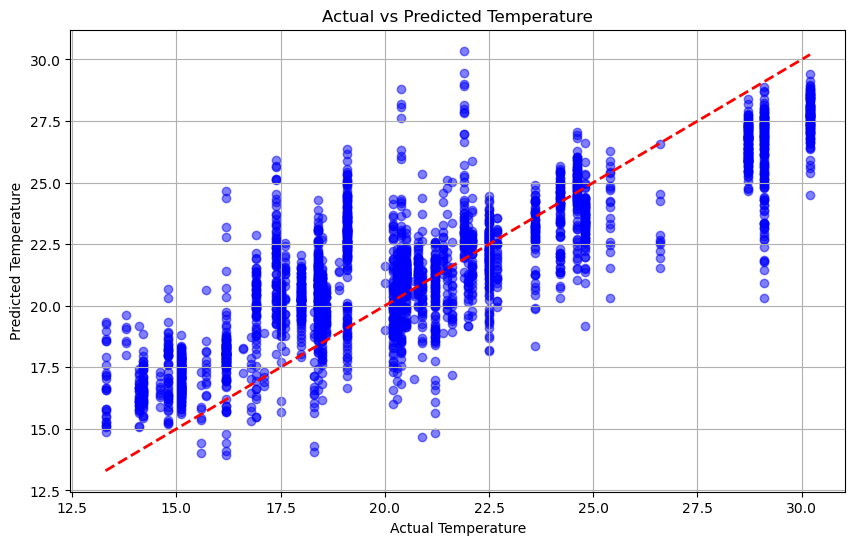

In [21]:
# plot of actual vs predicted temperatures
plt.figure(figsize=(10, 6))
plt.scatter(test_target, test_predictions, alpha=0.5, color='b')
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)], 'r--', lw=2)
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature')
plt.grid(True)
plt.show()

In [22]:
# reading the weekly forecast data
df = pd.read_csv("Forecast_27_04_2024.csv")

# making sure time is in datetime format
df['time'] = pd.to_datetime(df['time'])
df = df[df['time'].dt.time != pd.to_datetime('00:00:00').time()]

features= top_10_features

new_forecast = df[features]

# predicting temperatures
predicted_temps = second_optimized_linear_regression_model.predict(new_forecast)

# storring predictions in the DataFrame
df['predicted_temp'] = predicted_temps

# displaying  the first few rows to see the predictions
print(df.head())
# showing the t2m and temp first values
print(merged_data['t2m'].head())
print(merged_data['temp'].head())

                  time  number  latitude  longitude      cape        sp  \
50 2024-04-27 06:00:00       1     50.75       4.25  0.000000  99563.03   
51 2024-04-27 06:00:00       2     50.75       4.25  1.983521  99582.99   
52 2024-04-27 06:00:00       3     50.75       4.25  0.673584  99541.30   
53 2024-04-27 06:00:00       4     50.75       4.25  0.000000  99561.26   
54 2024-04-27 06:00:00       5     50.75       4.25  1.459595  99585.88   

          tcw      sshf      slhf        msl  ...  cin         sm         st  \
50  17.837006  470893.0 -170620.0  100434.58  ...  NaN  387.20148  281.37190   
51  18.107967  428106.0 -170620.0  100455.62  ...  NaN  375.54922  281.20700   
52  18.355345  465111.0 -228426.0  100412.50  ...  NaN  379.77640  281.42188   
53  17.825455  606481.5 -207914.0  100432.82  ...  NaN  388.22562  281.15350   
54  18.439087  489684.5 -155704.0  100458.02  ...  NaN  378.14800  281.22590   

     sd   sf       tcc        tp      mx2t6      mn2t6  predicted_te

In [23]:
forecast_init_time = datetime.strptime('2024-04-27', '%Y-%m-%d')

# initializing an empty dataframe to store the results
result_csv = pd.DataFrame()

for time in df['time'].unique():    
    time = pd.to_datetime(time)
    df_time = df[df['time'] == time]
    
    # calculating the forecast horizon in hours
    horizon_hours = (time - forecast_init_time).total_seconds() / 3600
    
    # extracting the  predicted temperatures
    corrected_temps = df_time['predicted_temp'].values

    # calculating quantiles
    quantiles = [np.quantile(corrected_temps, q) for q in [0.025, 0.25, 0.5, 0.75, 0.975]]

    # creating a new row with the quantile calculations
    new_row = {
        'forecast_date': time.strftime('%Y-%m-%d %H:%M:%S'), 
        'target': 't2m', 
        'horizon': f"{int(horizon_hours)} hour",
        'q0.025': quantiles[0], 
        'q0.25': quantiles[1], 
        'q0.5': quantiles[2], 
        'q0.75': quantiles[3], 
        'q0.975': quantiles[4]
    }
    
    # Append the new row to the result DataFrame
    result_csv = pd.concat([result_csv, pd.DataFrame([new_row])], ignore_index=True)

In [24]:
result_csv.to_csv('20240427_balmorhea.csv', index=False)

In [25]:
result_csv

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-04-27 06:00:00,t2m,6 hour,169.893468,169.974557,170.083850,170.152086,170.390853
1,2024-04-27 12:00:00,t2m,12 hour,174.681462,175.048810,175.277749,175.475723,175.884302
2,2024-04-27 18:00:00,t2m,18 hour,173.810806,174.020570,174.195630,174.488303,174.953102
3,2024-04-28 06:00:00,t2m,30 hour,172.181497,172.881504,173.043310,173.198202,173.632343
4,2024-04-28 12:00:00,t2m,36 hour,173.500634,174.359039,174.823542,175.069515,175.833663
5,2024-04-28 18:00:00,t2m,42 hour,172.941359,173.613053,173.810106,174.015592,174.365285
6,2024-04-29 06:00:00,t2m,54 hour,169.719259,170.183893,170.430369,170.571308,170.954171
7,2024-04-29 12:00:00,t2m,60 hour,175.998045,176.737688,177.018860,177.322991,177.987051
8,2024-04-29 18:00:00,t2m,66 hour,175.161588,175.525896,175.956055,176.248527,176.656741
9,2024-04-30 06:00:00,t2m,78 hour,172.006863,173.304505,173.650975,173.783724,174.235312
